# WAR Ratings

I used the formula and statistics provided by [FAN Graphs](https://library.fangraphs.com/misc/war/) 

* For Position Players

<center>
$  WAR = \frac {Batting Runs + Base Running Runs +Fielding Runs + Positional Adjustment + League Adjustment +Replacement Runs} {Runs Per Win} 
$
</center>

* For Pitchers

<center>
$  WAR =  \Big[ \big( \frac {League “FIP” – “FIP”} {Pitcher Specific Runs Per Win} + Replacement Level \big) * \frac{IP * Leverage Multiplier for Relievers }{9} \Big] + League Correction
$
</center>

## Reading in Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels.api as sm
import statsmodels.formula.api as smf


data =pd.read_csv(r"C:\Users\Derek\Desktop\core\batting.csv")
weights = pd.read_csv(r"C:\Users\Derek\Desktop\STT490\baseball\weights.csv")
pf = pd.read_csv(r"C:\Users\Derek\Desktop\STT490\baseball\park Factors.csv")
adv = pd.read_csv(r"C:\Users\Derek\Desktop\STT490\baseball\advanced.csv")
wOBA = pd.read_csv(r"C:\Users\Derek\Desktop\STT490\baseball\wOBA.csv")
field = pd.read_csv(r"C:\Users\Derek\Desktop\core\Fielding.csv")
teams = pd.read_csv(r"C:\Users\Derek\Desktop\core\teams.csv")
game = pd.read_csv(r"C:\Users\Derek\Desktop\STT490\baseball\games.csv")
pit = pd.read_csv(r"C:\Users\Derek\Desktop\core\pitching.csv")


weights[name].fillna(0 ,inplace = True)
data.fillna(0 ,inplace = True)
field.fillna(0 ,inplace = True)

Deleting before 1998 and Pitchers, the pitchers will be dealt with later.

In [1]:
field = field.loc[field['yearID']>=1998] 
field = field.loc[field['POS'] != 'P'] 
data = data.loc[data['yearID']>=1998] 

C:\Users\Derek\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


##  Batting Runs
### Adding weights to all Batting Stats

Adjusting weights to create better $r^2$, but it only brings down the value

In [2]:
weights['yearID']=weights['Season']

weights['wHR']=weights['wHR']
weights['w1B']=weights['w1B']
weights['w2B']=weights['w2B']
weights['w3B']=weights['w3B']
weights['wOBA']=weights['wOBA']

data1 = pd.merge(data, weights, on=['yearID'])

### Adding Player Positions

In [ ]:
field1=field[['yearID','playerID','teamID','POS','ZR']]
data1=pd.merge(data1,field1, on=['yearID','playerID','teamID'])

### Feature Engineering for Batting
#### Plate Appearances

In [ ]:
data1['PA']=data1['AB']+data1['BB']+data1['SF']+data1['SH']+data1['HBP']

#### Create singles

In [3]:
data1['1B']=(data1['H']-(data1['2B']+data1['3B']+data1['HR']))
data1['lgwOBA']=data1['wOBA']
data1=data1.drop(['wOBA'],axis=1)

#### Get Season and league totals for PA and R

In [4]:
rpa=data1.groupby('yearID', as_index=False).agg({"PA":"sum","R":"sum"})
rpa1=data1.groupby(('yearID','lgID'), as_index=False).agg({"PA":"sum","R":"sum"})

rpa['lgR/PA']=rpa['R']/rpa['PA']
rpa1['leagueR/PA']=rpa1['R']/rpa1['PA']

rpa1=rpa1[['yearID','leagueR/PA','lgID']]
rpa=rpa[['yearID','lgR/PA']]

rpa=pd.merge(rpa1,rpa, on=['yearID'])
data1=pd.merge(data1,rpa, on=['yearID','lgID'])
data1.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,...,runCS,R/PA,R/W,cFIP,ZR,PA,1B,lgwOBA,leagueR/PA,lgR/PA
count,20452.000000,20452.00000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,...,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000
mean,2007.100773,1.08894,74.334002,227.215236,30.534129,59.819137,11.920986,1.268971,6.662771,28.734549,...,-0.418241,0.119696,9.952583,3.095059,0.004401,254.309945,39.966409,0.324955,0.119946,0.119980
std,5.517542,0.30650,48.830972,186.604309,28.981158,53.554051,11.400494,1.914042,8.687162,28.959870,...,0.022416,0.006327,0.453557,0.062391,0.113962,209.921155,35.603224,0.008755,0.006652,0.006262
min,1998.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.460000,0.108000,9.117000,2.962000,0.000000,0.000000,0.000000,0.310000,0.106016,0.108491
25%,2002.000000,1.00000,30.000000,64.000000,7.000000,14.000000,2.000000,0.000000,1.000000,6.000000,...,-0.433000,0.114000,9.544000,3.048000,0.000000,71.000000,10.000000,0.316000,0.115948,0.113840
50%,2007.000000,1.00000,70.000000,178.000000,21.000000,44.000000,8.000000,1.000000,3.000000,19.000000,...,-0.420000,0.120000,9.994000,3.097000,0.000000,197.000000,30.000000,0.327000,0.120818,0.121655
75%,2012.000000,1.00000,116.000000,368.000000,47.000000,96.000000,19.000000,2.000000,9.000000,44.000000,...,-0.398000,0.124000,10.250000,3.134000,0.000000,412.000000,64.000000,0.331000,0.124615,0.123990
max,2016.000000,4.00000,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,165.000000,...,-0.377000,0.131000,10.795000,3.240000,10.000000,778.000000,225.000000,0.341000,0.133804,0.131596


#### wOBA(weighted on base average)

In [ ]:
data1['wOBAtop'] = ((data1['wBB']*data1['BB'])+(data1['wHBP']*data1['HBP'])+(data1['w1B']*data1['1B'])+(data1['w2B']*data1['2B'])+(data1['w3B']*data1['3B'])+(data1['wHR']*data1['HR']))
data1['wOBAdenom'] = ((data1['AB']+data1['BB']-data1['IBB']+data1['SF']+data1['HBP']))
data1['wOBA'] = data1['wOBAtop'] /data1['wOBAdenom'] 

#### wRAA(runs above average) and wRC(total runs created)

In [5]:
data1['wRAA'] = ((data1['wOBA']-data1['lgwOBA'])/data1['wOBAScale'])*data1['PA']
data1.fillna(0 ,inplace = True)
data1['wRC'] = ((((data1['wOBA']-data1['lgwOBA'])/data1['wOBAScale'])+data1['R/PA'])*data1['PA'])
data1.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,...,PA,1B,lgwOBA,leagueR/PA,lgR/PA,wOBAtop,wOBAdenom,wOBA,wRAA,wRC
count,20452.000000,20452.00000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,...,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000,20452.000000
mean,2007.100773,1.08894,74.334002,227.215236,30.534129,59.819137,11.920986,1.268971,6.662771,28.734549,...,254.309945,39.966409,0.324955,0.119946,0.119980,82.830844,251.265695,0.299953,0.960331,31.422152
std,5.517542,0.30650,48.830972,186.604309,28.981158,53.554051,11.400494,1.914042,8.687162,28.959870,...,209.921155,35.603224,0.008755,0.006652,0.006262,75.522591,207.571868,0.082697,12.518419,32.906105
min,1998.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.310000,0.106016,0.108491,0.000000,0.000000,0.000000,-39.018790,-4.101322
25%,2002.000000,1.00000,30.000000,64.000000,7.000000,14.000000,2.000000,0.000000,1.000000,6.000000,...,71.000000,10.000000,0.316000,0.115948,0.113840,19.041250,70.000000,0.268003,-5.156654,5.232442
50%,2007.000000,1.00000,70.000000,178.000000,21.000000,44.000000,8.000000,1.000000,3.000000,19.000000,...,197.000000,30.000000,0.327000,0.120818,0.121655,59.443000,195.000000,0.308731,-1.349366,19.839066
75%,2012.000000,1.00000,116.000000,368.000000,47.000000,96.000000,19.000000,2.000000,9.000000,44.000000,...,412.000000,64.000000,0.331000,0.124615,0.123990,131.401000,407.000000,0.343747,3.062379,49.015638
max,2016.000000,4.00000,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,165.000000,...,778.000000,225.000000,0.341000,0.133804,0.131596,362.220000,773.000000,2.017000,197.326165,273.834165


#### Park Adjustments
 renaming variables per team and per season

In [ ]:
pf['teamID'] = pf['Team'].replace({'Angels': 'LAA', 'Astros': 'HOU', 'Athletics': 'OAK', 'Blue Jays': 'TOR', 'Braves':'ATL', 'Brewers':'MIL','Cardinals':'SLN','Cubs' :'CHN','Devil Rays' :'TBA', 'Diamondbacks' :'ARI',
                    'Dodgers':'LAN','Expos':'MON','Giants':'SFN','Indians':'CLE','Mariners':'SEA','Marlins':'FLO','Mets':'NYN','Nationals':'WAS','Orioles':'BAL','Padres':'SDN','Phillies':'PHI','Pirates':'PIT',
                    'Rangers':'Tex','Rays':'TBA','Red Sox':'BOS','Reds':'CIN','Rockies':'COL','Royals':'KCA','Tigers':'DET','Twins':'MIN','White Sox':'CHA','Yankees':'NYA'})
pf['yearID'] = pf['Season']

pf1 = pf[['yearID','teamID','Basic']]
data2 = pd.merge(data1,pf1, on=['yearID','teamID'])

#### League At Bats

In [ ]:
dummy=data2.groupby('yearID', as_index=False).agg({"PA": "sum","wRC":"sum"})
dummy['lgPA']=dummy['PA']
dummy['lgwRC']=dummy['wRC']
dummy=dummy[['yearID','lgPA','lgwRC']]
data2 = pd.merge(data2,dummy, on=['yearID'])

data2['PF'] = data2['Basic']*.01
data2['wRC/PA'] = ((((data2['wRAA']/data2['PA'])+data2['lgR/PA'])+(data2['lgR/PA']-(data2['PF']*data2['lgR/PA'])))/(data2['lgwRC']/data2['lgPA']))
data2.fillna(0 ,inplace = True)

### Finally, Batting Runs

In [6]:
data2['Bat_Run'] = ((data2['wRAA']+((data2['lgR/PA']-(data2['PF']*data2['lgR/PA']))*data2['PA']))+((data2['lgR/PA']-(data2['leagueR/PA']))*data2['PA']))

## Base Running

### Feature Engineering for Base Running Runs
#### Creating league stats

In [ ]:
data2['outs']=data2['PA']-data2['H']
run=data2.groupby('yearID', as_index=False).agg({"R": "sum","outs":"sum","SB":"sum","1B":"sum","BB":"sum","IBB":"sum","CS":"sum","HBP":"sum"})
run['lgouts']=run['outs']
run['lgR']=run['R']
run['lg1B']=run['1B']
run['lgBB']=run['BB']
run['lgIBB']=run['IBB']
run['lgHBP']=run['HBP']
run['lgSB']=run['SB']
run['lgCS']=run['CS']
run=run[['yearID','lgouts','lgCS','lgR','lg1B','lgBB','lgIBB','lgSB','lgHBP']]

#### Creating wSB(weighted Stolen Bases) and league wSB

In [7]:
data3=pd.merge(data2,run, on=['yearID'])
data3['rpo']=data3['R']/data3['outs']
data3.fillna(0 ,inplace = True)
data3['runCS']=2*data3['rpo']+0.075
data3['lgwSB']=(data3['lgSB']*data3['runSB']+data3['lgCS'])/(data3['lg1B']+data3['lgBB']+data3['lgHBP']-data3['lgIBB'])
data3['wSB']=data3['SB']*data3['runSB']+data3['CS']*data3['runCS']/data3['lgSB']*(data3['1B']+data3['BB']+data3['HBP']-data3['IBB'])

#### Getting wGDP(weighted Ground Double Plays)

In [ ]:
wOBA['yearID']=wOBA['Season']
wOBA=wOBA[['yearID','wGDP']]
data4=pd.merge(data3,wOBA, on=['yearID'])
data4.fillna(0 ,inplace = True)

I don't have UBR so left it out
 + data3['UBR']

### Base Running Runs

In [8]:
data4['Base_Run']=(data4['wSB']+data4['wGDP'])

## Fielding Runs

Missing The data

## Positional Adjustment

In [9]:
data4['ADJ']=0
data4.loc[data4.POS == 'C', 'ADJ'] = 12.5 
data4.loc[data4.POS == '1B', 'ADJ'] = -12.5 
data4.loc[data4.POS == '2B', 'ADJ'] = 2.5 
data4.loc[data4.POS == '3B', 'ADJ'] = 2.5 
data4.loc[data4.POS == 'SS', 'ADJ'] = 7.5 
data4.loc[data4.POS == 'OF', 'ADJ'] = -7.5 

## League Adjustment

In [10]:
lg=data4.groupby(['lgID','yearID'], as_index=False).agg({"Bat_Run": "mean","Base_Run":"mean",###"Field_Runs":"sum",
                                                           "ADJ":"mean","PA":"sum"}).copy()

lg['lgADJ']=((-1*(lg['Bat_Run']+lg['Base_Run']###lg['Field_Run']
                      +lg['ADJ'])/lg['PA'])*lg['PA'] )        
lg.columns=['lgID','yearID','lgBat_Run','lgBase_Run','meanADJ','lgPA','lgADJ']
lg=lg[['lgID','yearID','lgBat_Run','lgBase_Run','meanADJ','lgADJ']]

In [ ]:
data4=pd.merge(data4,lg, on=['yearID','lgID'])
data4.describe()

## Runs per Win

In [ ]:
game['yearID']=game['Season']
game=game[['yearID','Inn']]
data4=pd.merge(data4,game, on=['yearID'])

data4['RPW']=(9*(data4['lgR']/data4['Inn'])*1.5+3)

## Replacement level runs

In [11]:
data4['RLR'] = ((570*(data4['G']/2430)))*((data4['RPW']/data4['lgPA']))*data4['PA']

## Positional Player WAR

In [12]:
data4['WAR'] = (data4['Bat_Run']+data4['Base_Run']+data4['ZR']+data4['ADJ']+data4['lgADJ']+data4['RLR']
             / data4['RPW'])/10
WAR=data4[['playerID','teamID','yearID','lgID','Bat_Run','Base_Run','ADJ','lgADJ','RLR','RPW','WAR']]
WAR = WAR.sort_values(by= ['WAR'], ascending=False)
print(WAR)

        playerID teamID  yearID lgID     Bat_Run  Base_Run   ADJ     lgADJ  \
6035   bondsba01    SFN    2004   NL  199.868310  0.832393  -7.5 -1.362498   
4674   bondsba01    SFN    2002   NL  158.804074  1.465042  -7.5 -1.469285   
3629   bondsba01    SFN    2001   NL  143.598609  2.684905  -7.5 -1.234784   
5431   bondsba01    SFN    2003   NL  124.025702  0.900000  -7.5 -0.165454   
4002    sosasa01    CHN    2001   NL  108.344499  0.052673  -7.5 -1.234784   
887    mcgwima01    SLN    1998   NL  111.462510  0.200000 -12.5 -0.497444   
10208  pujolal01    SLN    2008   NL   93.205705  0.670744   2.5 -0.762070   
11644  pujolal01    SLN    2009   NL  100.971071  3.596301 -12.5 -1.722510   
1840   jonesch06    ATL    1999   NL   77.456590  5.068238   7.5 -1.442841   
1839   jonesch06    ATL    1999   NL   77.456590  5.068238   2.5 -1.442841   
15889  cabremi01    DET    2013   AL   79.847489 -0.500000   2.5  1.211366   
3047   giambja01    OAK    2001   AL   94.374604  0.400000 -12.5

## Regression based off of Position Player WAR

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     310.9
Date:                Thu, 12 Apr 2018   Prob (F-statistic):           3.15e-55
Time:                        12:23:53   Log-Likelihood:                -1963.1
No. Observations:                 539   AIC:                             3930.
Df Residuals:                     537   BIC:                             3939.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.8785      0.399    202.893      0.0

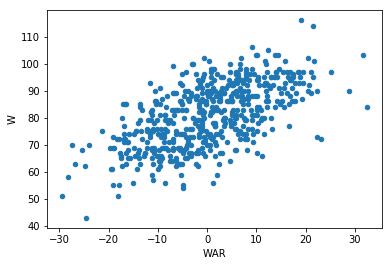

In [13]:
dat = WAR.groupby(('yearID','teamID'), as_index=False).agg({"WAR":"sum",})
teams = teams[['yearID','teamID','lgID','W','L','divID']]

regr = pd.merge(dat, teams, on=['yearID','teamID'])
model = smf.ols(formula='W ~ WAR' ,data=regr).fit()
print(model.summary())
x="WAR"
y="W"
regr.plot(kind = "scatter", x=x, y=y)
type(plt)
plt.show()


# War for Pitchers


In [ ]:
pit = pit.loc[pit['yearID']>=1998] 
pit = pit.loc[pit['IPouts']>=1] 

## Feature Engineering
### Create Innings Pitched and 9 Innings Pitched

In [14]:
p_data=pit
p_data['IP']=p_data['IPouts']/3
p_data['9IP']=p_data['IP']/9
pitc=p_data.groupby('yearID', as_index=False).agg({"ERA": "mean","HR":"sum","BB":"sum","HBP":"sum","SO":"sum","IP":"sum","R":"sum","9IP":"sum"})

### Adjusting to a 9 inning game

In [15]:
pitc.columns=['yearID','lgERA','lgHR','lgBB','lgHBP','lgK','lgIP','lgR','lg9IP']
pitc['RA9']=pitc['lgR']/pitc['lg9IP']
pitc['adj']=pitc['RA9']-pitc['lgERA']

## FIP(Feilding independent pitching)

In [16]:
p_data=pd.merge(p_data,pitc, on=['yearID'])
p_data['FIPcons']=p_data['lgERA']-(((13*p_data['lgHR'])+(3*(p_data['lgBB']+p_data['lgHBP']))-(2*p_data['lgK']))/p_data['lgIP'])
p_data['topifFIP']=((13*p_data['HR'])+(3*(p_data['BB']+p_data['HBP']))-(2*p_data['SO']))
p_data['botifFIP']=p_data['IP']
p_data['ifFIP']=(p_data['topifFIP']/p_data['botifFIP'])+p_data['FIPcons']
p_data['FIPr9']=p_data['ifFIP']+p_data['adj']

### Park Adj

In [17]:
p_data = pd.merge(p_data,pf1, on=['yearID','teamID'])
p_data['PF'] = p_data['Basic']*.01
p_data['pFIPr9']=p_data['FIPr9']/(p_data['Basic']/100)

### League adj

In [18]:
league = p_data.groupby(('yearID','lgID'), as_index=False).agg({"FIPr9": "mean"})
league.columns = ['yearID','lgID','lgFIPr9']
p_data = pd.merge(p_data,league, on=['yearID','lgID'])
p_data['RAAP9'] = p_data['lgFIPr9']-p_data['pFIPr9']
p_data['dRPW'] = (((((18-(p_data['IP']/p_data['G']))*(p_data['lgFIPr9']))+((p_data['IP']/p_data['G'])*p_data['pFIPr9']))/18)+2)*1.5
p_data['WPGAA'] = p_data['RAAP9']/p_data['dRPW']
p_data = p_data.sort_values(by= ['WPGAA'], ascending=False)

## Replacement level 

In [ ]:
p_data['rep_lev'] = .03*(1-(p_data['GS']/p_data['G']))+.12*(p_data['GS']/p_data['G'])
p_data['WPGAR'] = p_data['WPGAA']+p_data['rep_lev']
p_data['WAR']=p_data['WPGAR']*(p_data['IP']/9)
p_data = p_data.sort_values(by= ['WAR'], ascending=False)

* Adjust based on higher stakes, dont have LI


##  Pitcher WAR

In [ ]:
pWAR=p_data[['playerID','yearID','teamID','lgID','WAR']]

# WAR for all Players

In [20]:
WAR=pd.concat([WAR,pWAR], ignore_index=True)

## Regression for War and Actual Team Wins

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     742.1
Date:                Thu, 12 Apr 2018   Prob (F-statistic):          2.83e-103
Time:                        12:23:54   Log-Likelihood:                -1852.3
No. Observations:                 539   AIC:                             3709.
Df Residuals:                     537   BIC:                             3717.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.5108      0.685     94.148      0.0

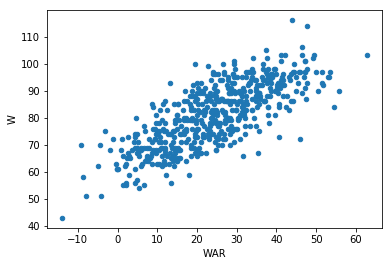

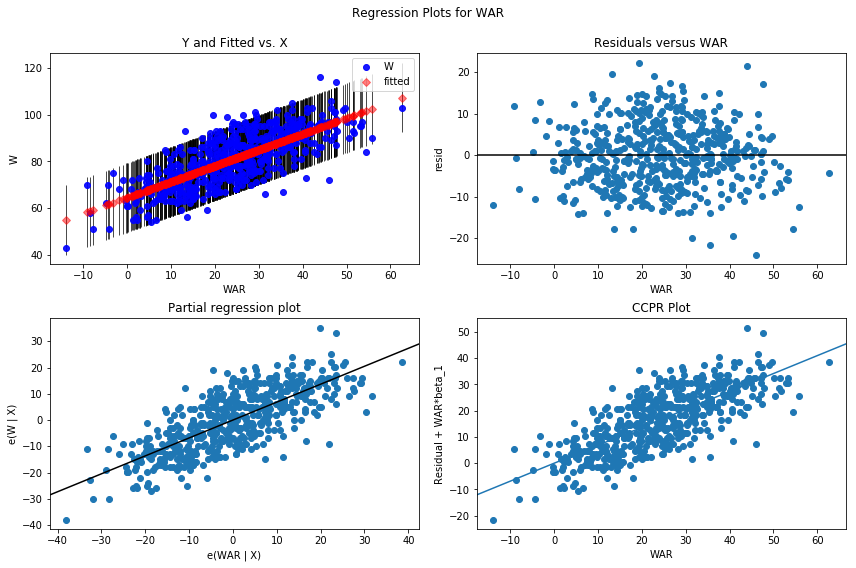

In [21]:
dat = WAR.groupby(('yearID','teamID'), as_index=False).agg({"WAR":"sum",})
teams = teams[['yearID','teamID','lgID','W','L','divID']]

regr = pd.merge(dat, teams, on=['yearID','teamID'])
model = smf.ols(formula='W ~ WAR' ,data=regr).fit()
print(model.summary())
x="WAR"
y="W"
regr.plot(kind = "scatter", x=x, y=y)
type(plt)
#plt.show()

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "WAR", fig=fig)
#plt.show()

![BARRY BONDS](https://media.giphy.com/media/WgZD3hluyopC8/giphy.gif)